<a href="https://colab.research.google.com/github/RicoBasyar/Word-Embedding-Effects-in-Indonesian-Social-Media-LSTM/blob/main/TF-IDF/LSTM_TF_IDF_LSTM_8_UNIT_200_EPOCHS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import string, re
from wordcloud import WordCloud
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import nltk

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **Dataset**

In [ ]:
df = pd.read_csv('result_df.csv')

In [ ]:
df = df.dropna()

In [ ]:
df = df.drop(0)

df = df.reset_index(drop=True)

In [ ]:
df

,label,Komentar
0,0,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,0,RT @baguscondromowo: Mereka terus melukai aksi...
2,0,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,0,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,0,RT @lisdaulay28: Waspada KTP palsu.....kawal P...
...,...,...
1758,0,Bangga sama suami yg selalu ingat istri disela...
1759,0,Apaoun pekerjaannya yg penting halal u tuk men...
1760,0,Gojek itu mayoritas pegangguran yang lama gak ...
1761,0,<USERNAME> aslinya cantik dan ayu loh mbak kr...


In [ ]:
print(df.label.value_counts())
plot = df.label.value_counts()
px.bar(plot)

0    978
1    785
Name: label, dtype: int64


In [ ]:
class_counts = df.label.value_counts()

min_samples = class_counts.min()

df_label_0 = df[df['label'] == 0].sample(n=min_samples, random_state=42)

df_label_1 = df[df['label'] == 1]

balanced_df = pd.concat([df_label_0, df_label_1])

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_df)

      label                                           Komentar
0         1  Sedih ya skrg ngamen di kawinan org .. mantan ...
1         1  iya,kelasnya penista agama,bs nya cm ngebacot ...
2         0  mrinding... bagus poll... d jaga ya dek kepolo...
3         1  #MataNajwaDebatJakarta pak anies banyak omdo d...
4         1                   "ANJING SINI LO BAKU HANTAM AYO"
...     ...                                                ...
1565      1  "Perasaan kemarin lengannya kekar banget kek p...
1566      1  "Cocok banget sama2 orang gak bener biar lah d...
1567      1            Bajingan lu silvy #DebatFinalPilkadaJKT
1568      1  Biarin,,,puas puasin mumpung deseu masih brasa...
1569      1   "Ya ampun ketiak dan lemaknya editan parah wkwk"

[1570 rows x 2 columns]


In [ ]:
print(balanced_df.label.value_counts())
plot = balanced_df.label.value_counts()
px.bar(plot)

1    785
0    785
Name: label, dtype: int64


In [ ]:
df = balanced_df

In [ ]:
print(df.label.value_counts())

1    785
0    785
Name: label, dtype: int64


In [ ]:
word_count_label_0 = df[df['label'] == 0]['Komentar'].str.split().apply(len).sum()
word_count_label_1 = df[df['label'] == 1]['Komentar'].str.split().apply(len).sum()

In [ ]:
word_count_label_0, word_count_label_1

(11540, 12195)

In [ ]:
w0_mean = df['Komentar'].str.split().apply(len).sum()/word_count_label_0
w1_mean = df['Komentar'].str.split().apply(len).sum()/word_count_label_1

In [ ]:
w0_mean, w1_mean

(2.0567590987868285, 1.946289462894629)

# **Data Preprocessing**

## **Cleneaning Data**

In [ ]:
def data_cleansing(text):
  text = re.sub(r'#\w+', '', text)
  text = re.sub(r'RT @\w+: ', '', text)
  text = re.sub(r'http\S+', '', text)
  text = text.lower()
  text = text.replace('username',' ')
  tb = string.punctuation
  trans = str.maketrans(tb,' '*len(tb))
  text = text.translate(trans)
  text = text.encode('ascii','ignore').decode('utf-8')
  text = re.sub(r'[^\x00-\x7f]',r'', text)
  text = text.replace('\n',' ')
  text = re.sub(r"\d+", "", text)
  return text

In [ ]:
df['Komentar'] = df['Komentar'].apply(data_cleansing)

In [ ]:
df

,label,Komentar
0,1,sedih ya skrg ngamen di kawinan org mantan ...
1,1,iya kelasnya penista agama bs nya cm ngebacot ...
2,0,mrinding bagus poll d jaga ya dek kepolo...
3,1,pak anies banyak omdo dulu waktu jd menteri t...
4,1,anjing sini lo baku hantam ayo
...,...,...
1565,1,perasaan kemarin lengannya kekar banget kek p...
1566,1,cocok banget sama orang gak bener biar lah di...
1567,1,bajingan lu silvy
1568,1,biarin puas puasin mumpung deseu masih brasa...


## **Ubah Singkatan**

In [ ]:
singkatan = pd.read_csv('kamus_singkatan.csv')
singkatan = singkatan.drop('Unnamed: 0', axis=1)

In [ ]:
singkatan

,singkatan,asli
0,abgny,abangnya
1,abis,habis
2,ad,ada
3,adek,adik
4,adik2,adik-adik
...,...,...
1498,trm,terima
1499,tukeran,tukar
1500,tw,tahu
1501,yup,ya


In [ ]:
new_row = [{'singkatan': 'in', 'asli': 'ini'},
            {'singkatan': 'ajg', 'asli': 'anjing'},
           {'singkatan': 'capek2', 'asli': 'capek capek'},
           {'singkatan': 'dimana2', 'asli': 'dimana mana'},
           {'singkatan': 'om2', 'asli': 'om om'},
           {'singkatan': 'bayi2', 'asli': 'bayi bayi'},
           {'singkatan': 'cakep2', 'asli': 'cakep cakep'}]
singkatan = singkatan.append(new_row, ignore_index=True)

<ipython-input-22-e60c46460bea>:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
singkatan

,singkatan,asli
0,abgny,abangnya
1,abis,habis
2,ad,ada
3,adek,adik
4,adik2,adik-adik
...,...,...
1505,capek2,capek capek
1506,dimana2,dimana mana
1507,om2,om om
1508,bayi2,bayi bayi


In [ ]:
singkatan_dict = dict(zip(singkatan['singkatan'], singkatan['asli']))

def ubah_singkatan(text):
    for a, b in singkatan_dict.items():
        pattern = r"\b" + re.escape(a) + r"\b"
        text = re.sub(pattern, b, text)
    return text

In [ ]:
df['Komentar'] = df['Komentar'].apply(ubah_singkatan)

In [ ]:
df

,label,Komentar
0,1,sedih ya sekarang ngamen di kawinan orang m...
1,1,iya kelasnya penista agama bisa nya cuma ngeba...
2,0,mrinding bagus poll di jaga ya dek kepol...
3,1,bapak anies banyak omdo dulu waktu jadi mente...
4,1,anjing sini kamu baku hantam ayo
...,...,...
1565,1,perasaan kemarin lengannya kekar sekali kek p...
1566,1,cocok sekali sama orang tidak benar biar lah ...
1567,1,bajingan kamu silvy
1568,1,biarin puas puasin mumpung deseu masih beras...


## **Stopword**

In [ ]:
def tambah_stopword():
  tambah_stopword = pd.read_csv('stopwordbahasa.csv', header=None)
  tambah_stopword
  tambah_stopword_list = tambah_stopword.values.flatten().tolist()
  return tambah_stopword_list

In [ ]:
factory=StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

In [ ]:
def stopwords(text):
  tambahlagi = ['nya','kak','si','bang','arti', 'deh','eh','sih','sok','kek','ahok', 'basuki', 'hahaha', 'tuh', 'ih', 'mel', 'tenar'
  , 'jakarta','mbak','mba','eh','moga','pakai','pilih','anies','pilih','kali','pakai','loh','mah'
  ,'haha','mah','jaga','ni','ko','kok','wkwk','pilkada','pimpin','nagita','iya','jaga','btp','orang','kena','om','elu']
  regex = r'\b(?:{})\b'.format('|'.join(map(re.escape, tambah_stopword()+tambahlagi)))
  text = re.sub(regex, '', text)
  text = stopword.remove(text)
  return text

In [ ]:
df['Komentar'] = df['Komentar'].apply(stopwords)

In [ ]:
df

,label,Komentar
0,1,sedih ngamen kawinan mantan istri mahhhh...
1,1,kelasnya penista agama ngebacot arogan s...
2,0,mrinding bagus poll dek kepolosannya ...
3,1,omdo menteri terobosannya bicara ky...
4,1,anjing baku hantam ayo
...,...,...
1565,1,perasaan kemarin lengannya kekar petinju ...
1566,1,cocok biar hancur
1567,1,bajingan silvy
1568,1,biarin puas puasin mumpung deseu berasa mud...


## **Stemming**

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
  return stemmer.stem(text)

In [ ]:
df['Komentar'] = df['Komentar'].apply(stemming)

In [ ]:
df

,label,Komentar
0,1,sedih ngamen kawin mantan istri mahhhh pesawat...
1,1,kelas nista agama ngebacot arogan sk bilang ta...
2,0,mrinding bagus poll dek polos smpek aw dkk
3,1,omdo menteri terobos bicara ky jago
4,1,anjing baku hantam ayo
...,...,...
1565,1,asa kemarin lengan kekar tinju ketiak hitam fo...
1566,1,cocok biar hancur
1567,1,bajing silvy
1568,1,biarin puas puasin mumpung deseu asa muda tua ...


## **WordCloud**

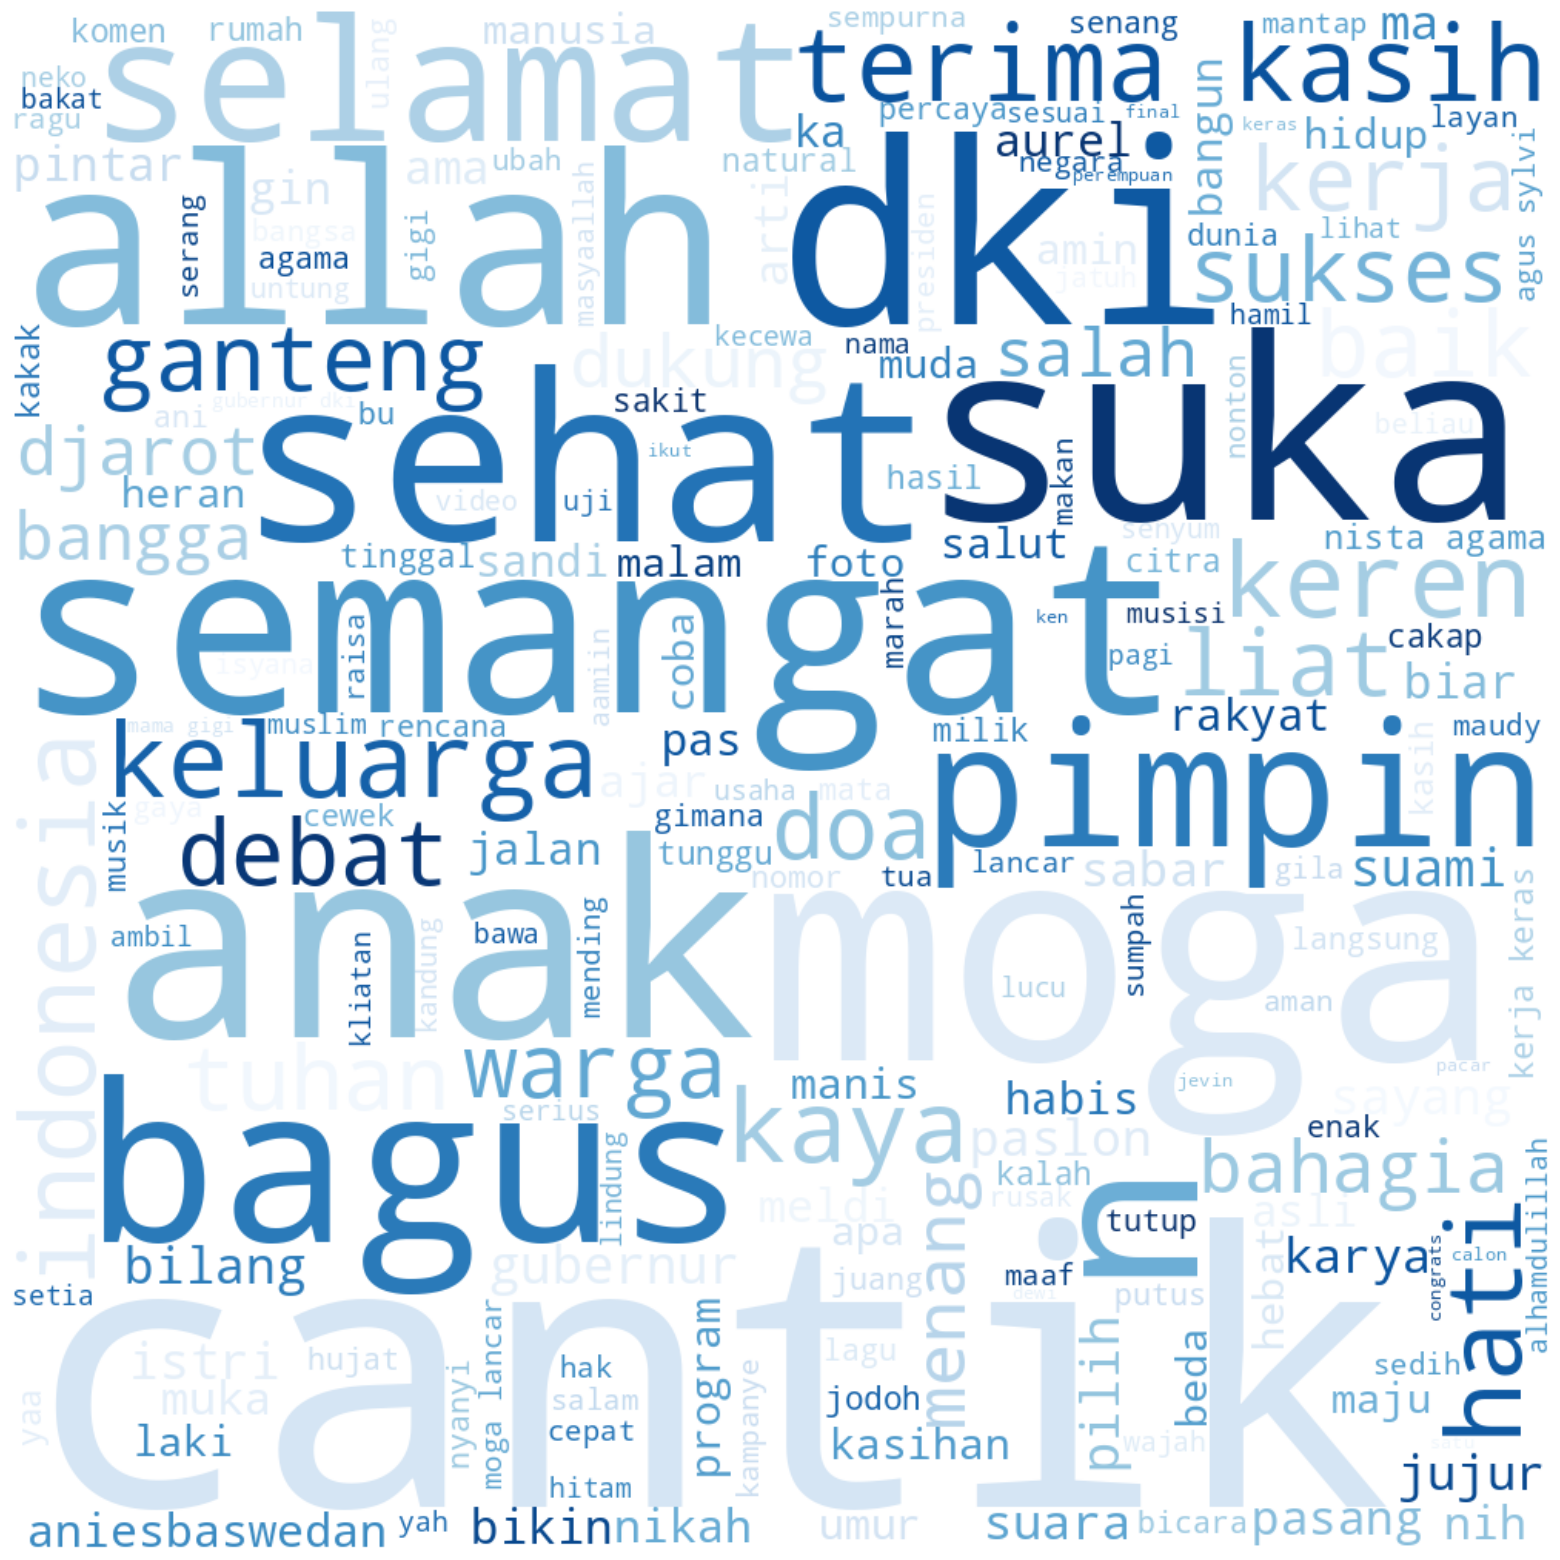

In [ ]:
# value 0
trains0=df[df['label']==0]
all_text=' '.join(word for word in trains0['Komentar'])
word_cloud=WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
plt.figure(figsize=(20,20))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

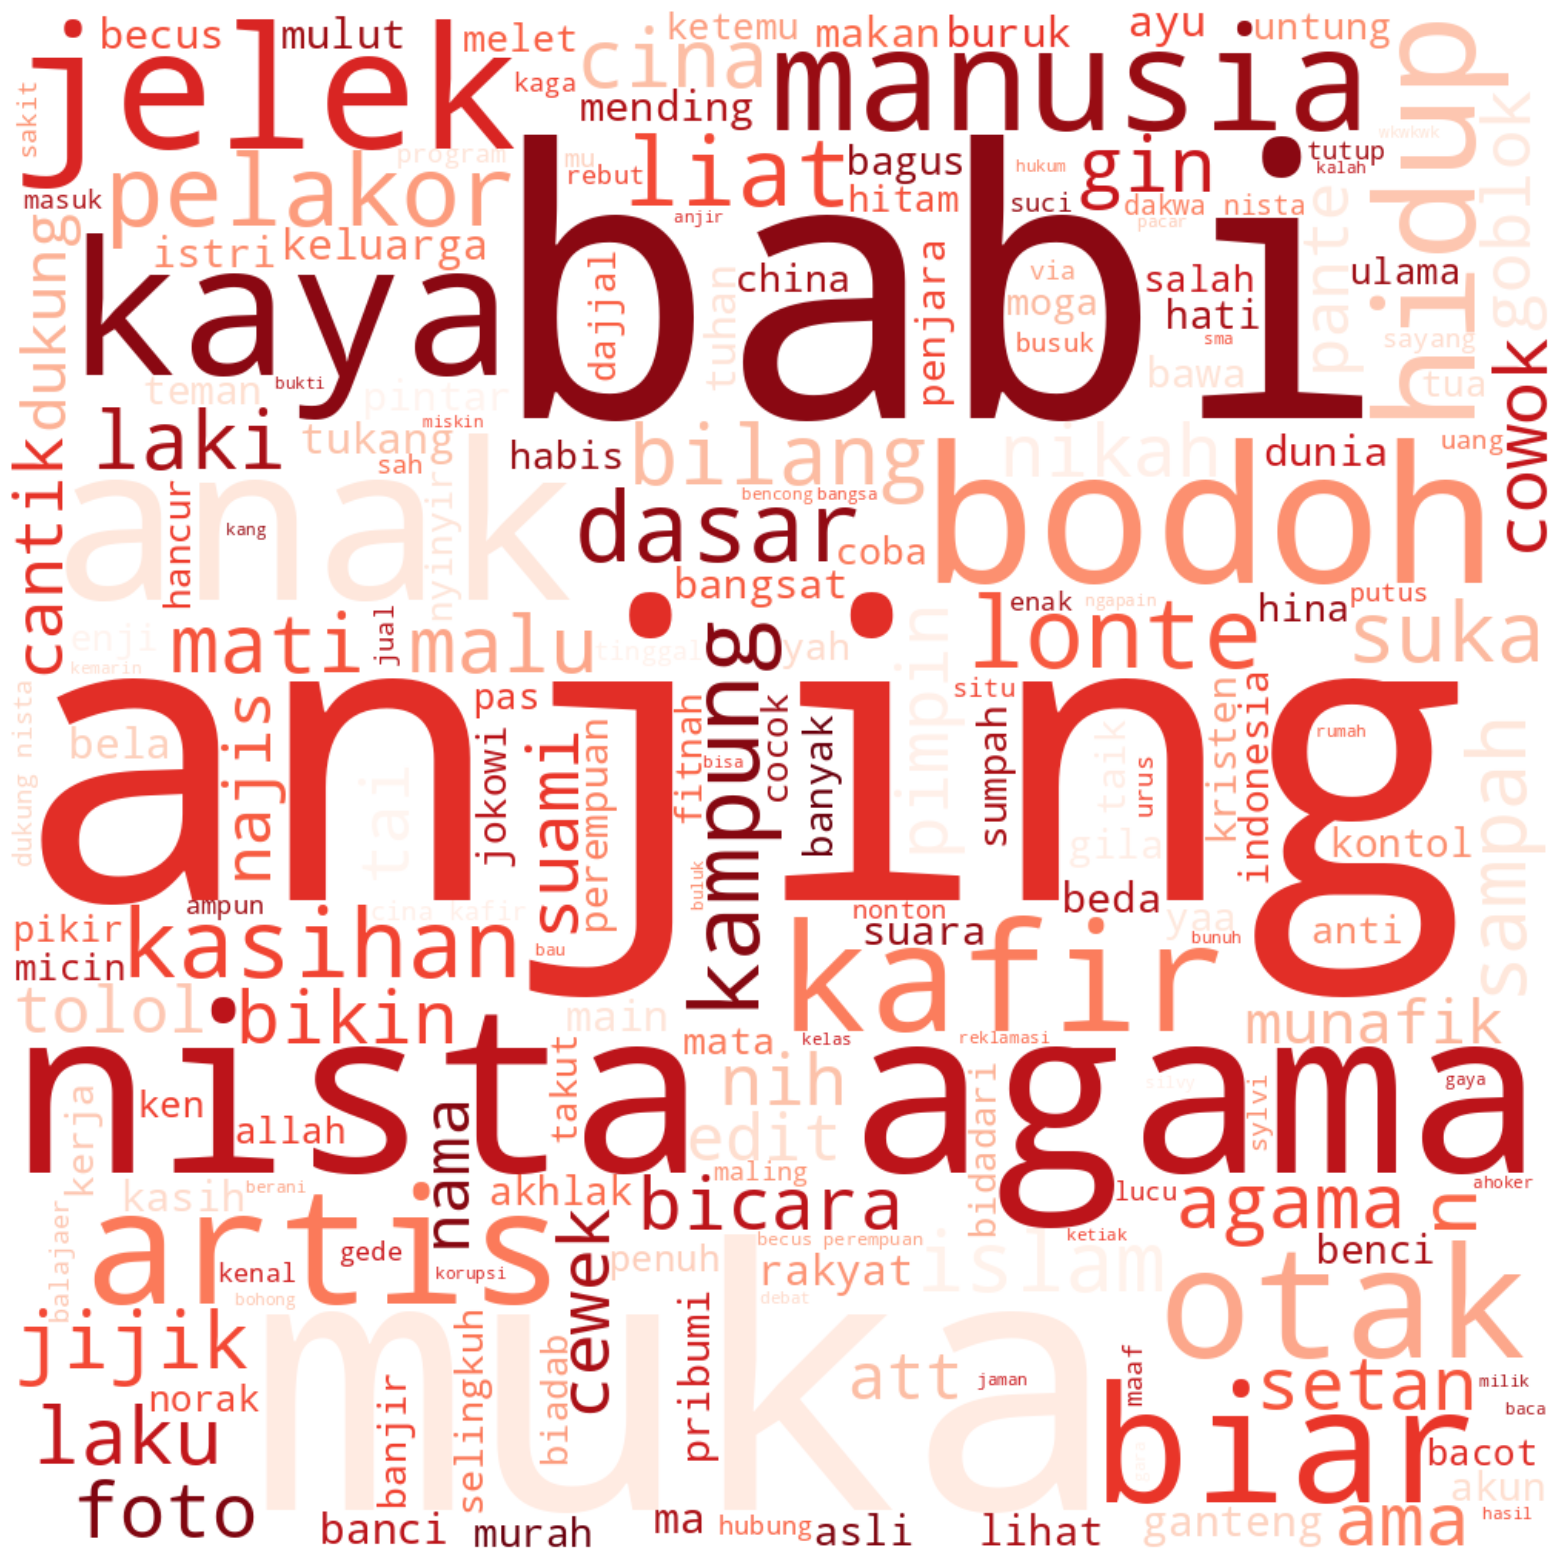

In [ ]:
# value 1
trains1=df[df['label']==1]
all_text=' '.join(word for word in trains1['Komentar'])
word_cloud=WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
plt.figure(figsize=(20,20))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

## Tokenize

In [ ]:
tokenizer = Tokenizer()
def tokenize_text(text):
  tokenizer.fit_on_texts([text])
  tokenized_list = [text.split() for text in [text]]
  return tokenizer.texts_to_sequences([text])[0], tokenized_list[0]

In [ ]:
df['Komentar.tokenize'], df['Komentar.tokenize.text'] = zip(*df['Komentar'].apply(tokenize_text))

In [ ]:
df

,label,Komentar,Komentar.tokenize,Komentar.tokenize.text
0,1,sedih ngamen kawin mantan istri mahhhh pesawat...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[sedih, ngamen, kawin, mantan, istri, mahhhh, ..."
1,1,kelas nista agama ngebacot arogan sk bilang ta...,"[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 2...","[kelas, nista, agama, ngebacot, arogan, sk, bi..."
2,0,mrinding bagus poll dek polos smpek aw dkk,"[30, 31, 32, 33, 34, 35, 36, 37]","[mrinding, bagus, poll, dek, polos, smpek, aw,..."
3,1,omdo menteri terobos bicara ky jago,"[38, 39, 40, 41, 42, 43]","[omdo, menteri, terobos, bicara, ky, jago]"
4,1,anjing baku hantam ayo,"[44, 45, 46, 47]","[anjing, baku, hantam, ayo]"
...,...,...,...,...
1565,1,asa kemarin lengan kekar tinju ketiak hitam fo...,"[217, 221, 678, 4071, 4072, 228, 94, 47, 678, ...","[asa, kemarin, lengan, kekar, tinju, ketiak, h..."
1566,1,cocok biar hancur,"[179, 12, 292]","[cocok, biar, hancur]"
1567,1,bajing silvy,"[4074, 167]","[bajing, silvy]"
1568,1,biarin puas puasin mumpung deseu asa muda tua ...,"[617, 881, 4075, 1509, 4076, 195, 148, 133, 40...","[biarin, puas, puasin, mumpung, deseu, asa, mu..."


In [ ]:
print(tokenizer.index_word)

{1: 'agama', 2: 'anak', 3: 'cantik', 4: 'anjing', 5: 'muka', 6: 'babi', 7: 'nista', 8: 'moga', 9: 'kaya', 10: 'suka', 11: 'kasih', 12: 'biar', 13: 'liat', 14: 'artis', 15: 'allah', 16: 'dki', 17: 'bodoh', 18: 'n', 19: 'jelek', 20: 'dukung', 21: 'pimpin', 22: 'bilang', 23: 'kafir', 24: 'manusia', 25: 'kerja', 26: 'bagus', 27: 'hidup', 28: 'keluarga', 29: 'kasihan', 30: 'ganteng', 31: 'hati', 32: 'indonesia', 33: 'sehat', 34: 'otak', 35: 'semangat', 36: 'islam', 37: 'tuhan', 38: 'suami', 39: 'gin', 40: 'laki', 41: 'ama', 42: 'terima', 43: 'bikin', 44: 'nikah', 45: 'selamat', 46: 'nih', 47: 'foto', 48: 'istri', 49: 'debat', 50: 'dasar', 51: 'cina', 52: 'kampung', 53: 'suara', 54: 'salah', 55: 'keren', 56: 'pelakor', 57: 'gubernur', 58: 'lonte', 59: 'pintar', 60: 'bicara', 61: 'rakyat', 62: 'bahagia', 63: 'jijik', 64: 'bangga', 65: 'asli', 66: 'sayang', 67: 'laku', 68: 'cewek', 69: 'malu', 70: 'doa', 71: 'baik', 72: 'menang', 73: 'mati', 74: 'djarot', 75: 'perempuan', 76: 'pilih', 77: 'dun

In [ ]:
file_name = 'processed_dataset.xlsx'
df.to_excel(file_name)

# **TF-IDF**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['Komentar.tokenize.text'] , df['label'], test_size=0.3, stratify=df['label'],
                                                    random_state=30)

def identity_tokenizer(tokens):
    return tokens

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)

# Fit-transform the training data
x_train_tfidf = vectorizer.fit_transform(x_train)

# Transform the test data
x_test_tfidf = vectorizer.transform(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [ ]:
x_train_tfidf

<1099x3272 sparse matrix of type '<class 'numpy.float64'>'
	with 8031 stored elements in Compressed Sparse Row format>

In [ ]:
print(x_train_tfidf)

  (0, 2275)	0.7768098132765879
  (0, 301)	0.6297352729498266
  (1, 2070)	0.4929370167326064
  (1, 247)	0.2682331434647907
  (1, 2123)	0.4929370167326064
  (1, 2254)	0.4461953309384484
  (1, 2527)	0.4929370167326064
  (2, 2598)	0.24272390229997376
  (2, 1207)	0.2183340559698783
  (2, 137)	0.3307772559731732
  (2, 1107)	0.2680467811184568
  (2, 680)	0.3307772559731732
  (2, 1337)	0.4366681119397566
  (2, 2979)	0.22658419256041934
  (2, 3196)	0.3307772559731732
  (2, 2216)	0.4678765018184206
  (2, 247)	0.1799934274452573
  (3, 536)	0.39168971550488535
  (3, 150)	0.4609690483089638
  (3, 3218)	0.4354001078785576
  (3, 1941)	0.34293176864756786
  (3, 2225)	0.4609690483089638
  (3, 1445)	0.338258463133666
  (4, 773)	0.32429445467420104
  (4, 292)	0.42808256080790746
  :	:
  (1095, 2473)	0.425318455959737
  (1095, 275)	0.3731927918916757
  (1095, 558)	0.23952867495136046
  (1096, 307)	0.4058089627006816
  (1096, 1972)	0.3905220953439173
  (1096, 1802)	0.7083408242498128
  (1096, 1539)	0.42551

In [ ]:
print(y_train.value_counts())
print(y_test.value_counts())

0    550
1    549
Name: label, dtype: int64
1    236
0    235
Name: label, dtype: int64


# **LSTM**

In [ ]:
# Convert tf idf array ke dense array buat LSTM
x_train_array = x_train_tfidf.toarray()
x_test_array = x_test_tfidf.toarray()

num_features = x_train_array.shape[1]
x_train_lstm = np.reshape(x_train_array, (x_train_array.shape[0], 1, num_features))
x_test_lstm = np.reshape(x_test_array, (x_test_array.shape[0], 1, num_features))

# Convert label ke format binary
y_train_binary = np.array(y_train)
y_test_binary = np.array(y_test)

# cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)

cv_scores = []
cv_precision_scores = []
cv_recall_scores = []
cv_f1_scores = []

for train_index, val_index in kfold.split(x_train_lstm, y_train_binary):
    # Bagi data ke training dan validation set
    x_train_fold, x_val_fold = x_train_lstm[train_index], x_train_lstm[val_index]
    y_train_fold, y_val_fold = y_train_binary[train_index], y_train_binary[val_index]

    # Model LSTM
    model = Sequential()
    model.add(Dropout(0.5, input_shape=(1, num_features)))
    model.add(LSTM(units=8))
    model.add(Dropout(0.8))
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train model
    history = model.fit(x_train_fold, y_train_fold, epochs=200, batch_size=32, validation_data=(x_val_fold, y_val_fold), verbose=2)
    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']

    # Evaluasi model di validation set
    _, accuracy = model.evaluate(x_val_fold, y_val_fold)
    cv_scores.append(accuracy)

    # Predict di validation set
    y_val_pred = model.predict(x_val_fold)
    y_val_pred_binary = np.round(y_val_pred).flatten()

    val_precision = precision_score(y_val_fold, y_val_pred_binary)
    val_recall = recall_score(y_val_fold, y_val_pred_binary)
    val_f1 = f1_score(y_val_fold, y_val_pred_binary)

    cv_precision_scores.append(val_precision)
    cv_recall_scores.append(val_recall)
    cv_f1_scores.append(val_f1)

# Nilai scross validation rata rata dan standard deviasi
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

mean_precision = np.mean(cv_precision_scores)
std_precision = np.std(cv_precision_scores)

mean_recall = np.mean(cv_recall_scores)
std_recall = np.std(cv_recall_scores)

mean_f1 = np.mean(cv_f1_scores)
std_f1 = np.std(cv_f1_scores)

# Evaluasi model di test set
test_loss, test_accuracy = model.evaluate(x_test_lstm, y_test_binary)

y_test_pred = model.predict(x_test_lstm)
y_test_pred_binary = np.round(y_test_pred).flatten()

test_precision = precision_score(y_test_binary, y_test_pred_binary)
test_recall = recall_score(y_test_binary, y_test_pred_binary)
test_f1 = f1_score(y_test_binary, y_test_pred_binary)

print("Cross-Validation Accuracy: {:.4f} (+/- {:.4f})".format(mean_cv_score, std_cv_score))
print("Cross-Validation Precision: {:.4f} (+/- {:.4f})".format(mean_precision, std_precision))
print("Cross-Validation Recall: {:.4f} (+/- {:.4f})".format(mean_recall, std_recall))
print("Cross-Validation F1 Score: {:.4f} (+/- {:.4f})".format(mean_f1, std_f1))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)

Epoch 1/200
28/28 - 8s - loss: 0.6931 - accuracy: 0.4778 - val_loss: 0.6925 - val_accuracy: 0.5773 - 8s/epoch - 301ms/step
Epoch 2/200
28/28 - 0s - loss: 0.6916 - accuracy: 0.5540 - val_loss: 0.6918 - val_accuracy: 0.6318 - 495ms/epoch - 18ms/step
Epoch 3/200
28/28 - 0s - loss: 0.6908 - accuracy: 0.5666 - val_loss: 0.6911 - val_accuracy: 0.6727 - 385ms/epoch - 14ms/step
Epoch 4/200
28/28 - 0s - loss: 0.6893 - accuracy: 0.5961 - val_loss: 0.6901 - val_accuracy: 0.7182 - 188ms/epoch - 7ms/step
Epoch 5/200
28/28 - 0s - loss: 0.6872 - accuracy: 0.6382 - val_loss: 0.6890 - val_accuracy: 0.7364 - 215ms/epoch - 8ms/step
Epoch 6/200
28/28 - 0s - loss: 0.6849 - accuracy: 0.6815 - val_loss: 0.6874 - val_accuracy: 0.7773 - 204ms/epoch - 7ms/step
Epoch 7/200
28/28 - 0s - loss: 0.6824 - accuracy: 0.6746 - val_loss: 0.6854 - val_accuracy: 0.7500 - 192ms/epoch - 7ms/step
Epoch 8/200
28/28 - 0s - loss: 0.6801 - accuracy: 0.6871 - val_loss: 0.6830 - val_accuracy: 0.7727 - 192ms/epoch - 7ms/step
Epoch 9

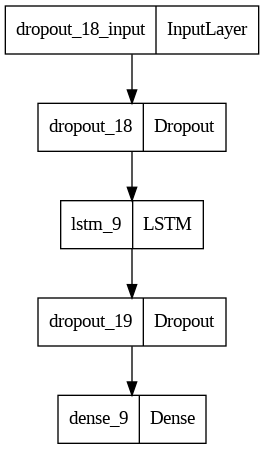

In [ ]:
plot_model(model)

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_18 (Dropout)        (None, 1, 3272)           0         
                                                                 
 lstm_9 (LSTM)               (None, 8)                 104992    
                                                                 
 dropout_19 (Dropout)        (None, 8)                 0         
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 105001 (410.16 KB)
Trainable params: 105001 (410.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


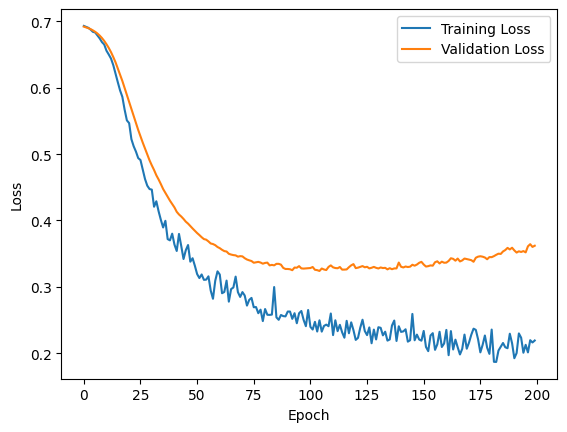

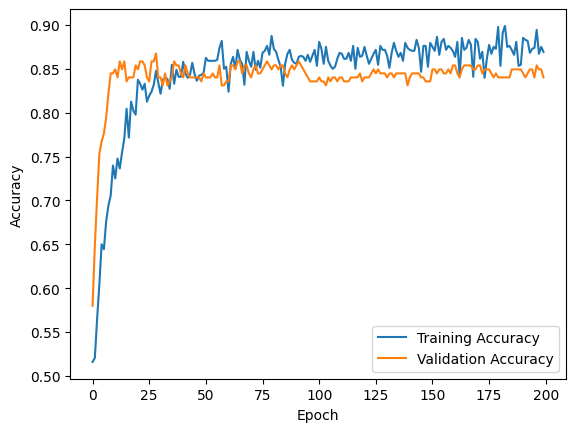

In [ ]:
# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print(train_loss)
print(val_loss)

[0.6931988000869751, 0.6918140053749084, 0.6903539896011353, 0.6876579523086548, 0.6842896938323975, 0.6833314299583435, 0.6789367198944092, 0.6743790507316589, 0.6688100695610046, 0.6651826500892639, 0.6558511853218079, 0.6501349210739136, 0.6439878940582275, 0.6340920925140381, 0.6209646463394165, 0.6083390116691589, 0.59596848487854, 0.586320161819458, 0.5671138763427734, 0.5508517026901245, 0.5467290878295898, 0.5225099921226501, 0.5118470191955566, 0.5038174986839294, 0.4940163791179657, 0.4911143481731415, 0.47661781311035156, 0.46253806352615356, 0.45247307419776917, 0.4473817050457001, 0.4464971423149109, 0.42072272300720215, 0.4289487898349762, 0.4138651490211487, 0.40089818835258484, 0.38947102427482605, 0.3995257318019867, 0.3719382584095001, 0.3700251579284668, 0.38009023666381836, 0.36370304226875305, 0.35402634739875793, 0.379714697599411, 0.3614467978477478, 0.34193336963653564, 0.3551512062549591, 0.3629956543445587, 0.3379191756248474, 0.343120813369751, 0.331809431314

In [ ]:
print(train_accuracy)
print(val_accuracy)

[0.5159090757369995, 0.5204545259475708, 0.5647727251052856, 0.6045454740524292, 0.6499999761581421, 0.644318163394928, 0.6761363744735718, 0.6943181753158569, 0.7056818008422852, 0.7397727370262146, 0.7250000238418579, 0.7477272748947144, 0.7363636493682861, 0.7545454502105713, 0.7704545259475708, 0.8045454621315002, 0.7715908885002136, 0.8125, 0.8022727370262146, 0.7977272868156433, 0.8374999761581421, 0.8329545259475708, 0.8261363506317139, 0.8329545259475708, 0.8125, 0.8193181753158569, 0.8238636255264282, 0.831818163394928, 0.8477272987365723, 0.8340908885002136, 0.8215909004211426, 0.8374999761581421, 0.8397727012634277, 0.8386363387107849, 0.8272727131843567, 0.8545454740524292, 0.8329545259475708, 0.8488636612892151, 0.8409090638160706, 0.8409090638160706, 0.8579545617103577, 0.8443182110786438, 0.8397727012634277, 0.8431817889213562, 0.8568181991577148, 0.8443182110786438, 0.8363636136054993, 0.8420454263687134, 0.8431817889213562, 0.8454545736312866, 0.862500011920929, 0.8590

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

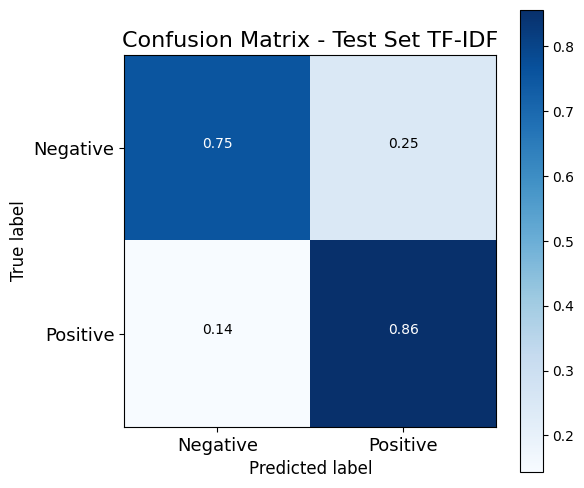

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

# Create confusion matrix
cnf_matrix = confusion_matrix(y_test_binary, y_test_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Positive'], title='Confusion Matrix - Test Set TF-IDF')
plt.show()

In [ ]:
def preprocess_unseen_data(text):
    text = data_cleansing(text)
    text = ubah_singkatan(text)
    text = stopwords(text)
    text = stemming(text)
    return text

def preprocess_and_predict(unseen_data):
    preprocessed_data = preprocess_unseen_data(unseen_data)
    tfidf_features = vectorizer.transform([preprocessed_data])
    tfidf_features_array = tfidf_features.toarray()
    num_features = tfidf_features_array.shape[1]
    tfidf_features_lstm = np.reshape(tfidf_features_array, (1, 1, num_features))
    predictions = model.predict(tfidf_features_lstm)
    predicted_classes = (predictions > 0.4).astype(int)
    if predictions > 0.4 :
      print("Cyberbullying")
    else:
      print("Tidak Cyberbullying")

    return predicted_classes[0], predictions

In [ ]:
x_test_tfidf_dense = x_test_tfidf.toarray()
x_test_tfidf_reshaped = x_test_tfidf_dense.reshape((x_test_tfidf_dense.shape[0], 1, x_test_tfidf_dense.shape[1]))

In [ ]:
predicted_probabilities = model.predict(x_test_tfidf_reshaped)
predicted_labels = (predicted_probabilities > 0.5).astype(int)

15/15 [==============================] - 0s 3ms/step


In [ ]:
y_test

409     1
1170    1
336     0
88      1
826     0
       ..
168     0
1371    0
374     1
474     0
770     0
Name: label, Length: 471, dtype: int64

In [ ]:
predicted_labels

array([[1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
    

In [ ]:
file_name1 = 'y_test.xlsx'
y_test.to_excel(file_name1)

In [ ]:
predicted_labels_df = pd.DataFrame(predicted_labels)
file_name2 = 'predicted_labels.xlsx'
predicted_labels_df.to_excel(file_name2)